### Sentiment analysis using Keras and Word2Vec  
Data from Kaggle: https://inclass.kaggle.com/c/si650winter11  
Based on code from https://github.com/PacktPublishing/Deep-Learning-with-Keras/blob/master/Chapter05/learn_embedding_from_scratch.py  
See also  https://github.com/sujitpal/intro-dl-talk-code/blob/master/src/04-umich-sentiment-analysis.ipynb

In [74]:
from keras.layers import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np

np.random.seed(42)

In [75]:
INPUT_FILE = "umich_train.txt"
VOCAB_SIZE = 5000
EMBED_SIZE = 100
NUM_FILTERS = 256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [76]:
counter = collections.Counter()

with open(INPUT_FILE, "r", encoding='utf-8') as f:
    maxlen = 0
    for line in f:
        _, sent = line.strip().split("\t")
        words = [x.lower() for x in nltk.word_tokenize(sent)]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1
    
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}
    
xs, ys = [], []
with open(INPUT_FILE, "r", encoding='utf-8') as f:
    for line in f:
        label, sent = line.strip().split("\t")
        ys.append(int(label))
        words = [x.lower() for x in nltk.word_tokenize(sent)]
        wids = [word2index[word] for word in words]
        xs.append(wids)

X = pad_sequences(xs, maxlen=maxlen)
y = np_utils.to_categorical(ys, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4960, 42) (2126, 42) (4960, 2) (2126, 2)


Train on 4960 samples, validate on 2126 samples
Epoch 1/20
4960/4960 [==============================] - 9s - loss: 0.2554 - acc: 0.9065 - val_loss: 0.0348 - val_acc: 0.9845
Epoch 2/20
4960/4960 [==============================] - 9s - loss: 0.0171 - acc: 0.9933 - val_loss: 0.0205 - val_acc: 0.9929
Epoch 3/20
4960/4960 [==============================] - 9s - loss: 0.0061 - acc: 0.9984 - val_loss: 0.0169 - val_acc: 0.9939
Epoch 4/20
4960/4960 [==============================] - 8s - loss: 0.0030 - acc: 0.9992 - val_loss: 0.0170 - val_acc: 0.9934
Epoch 5/20
4960/4960 [==============================] - 9s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0167 - val_acc: 0.9944
Epoch 6/20
4960/4960 [==============================] - 9s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0160 - val_acc: 0.9939
Epoch 7/20
4960/4960 [==============================] - 9s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0160 - val_acc: 0.9934
Epoch 8/20
4960/4960 [==============================] - 9s - loss: 0.0014 - a

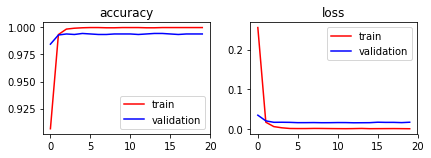

Test score: 0.017, accuracy: 0.994


In [77]:
model = Sequential()
model.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen))
#model.add(SpatialDropout1D(Dropout(0.2))) #---- not supported in keras 2
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, Ytest))              

# plot loss function
plt.subplot(221)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(222)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# evaluate model
score = model.evaluate(X_test, y_test, verbose=0 ) # verbose=1 to see output
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

In [78]:
y_test_labels = [np.argmax(i) for i in y_test] # need to bring labels back for the test set
preds = model.predict_classes(X_test)
print("\nConfusion matrix:\n", confusion_matrix(y_test_labels, preds))
print("\nClassification report:\n",classification_report(y_test_labels, preds))

2048/2126 [===========================>..] - ETA: 0s
Confusion matrix:
 [[ 909    5]
 [   8 1204]]

Classification report:
              precision    recall  f1-score   support

          0       0.99      0.99      0.99       914
          1       1.00      0.99      0.99      1212

avg / total       0.99      0.99      0.99      2126

